Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

In [1]:
!pip install geopy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/sahil-gidwani/ML/main/dataset/uber.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [4]:
# 1. Pre-process the dataset
df.shape

(200000, 9)

In [5]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
df.drop(columns=["Unnamed: 0", "key"], inplace=True)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [7]:
df.isnull()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
199995,False,False,False,False,False,False,False
199996,False,False,False,False,False,False,False
199997,False,False,False,False,False,False,False
199998,False,False,False,False,False,False,False


In [8]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [9]:
df['dropoff_latitude'].fillna(value = df['dropoff_latitude'].mean(), inplace = True)
df['dropoff_longitude'].fillna(value = df['dropoff_longitude'].median(), inplace = True)

In [10]:
df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [11]:
# From the above output, we see that the data type of 'pickup_datetime' is 'object
# But 'pickup_datetime'is a date time stamp variable, which is wrongly interpreted as 'object', so we will convert this variable data type to 'datetime'.
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [12]:
# We will extract time feature from the 'pickup_datetime'
# We will add a variable which measures the distance between pickup and drop
df = df.assign(hour = df.pickup_datetime.dt.hour,
               day = df.pickup_datetime.dt.day,
               month = df.pickup_datetime.dt.month,
               year = df.pickup_datetime.dt.year,
               dayofweek = df.pickup_datetime.dt.dayofweek)

In [13]:
df = df.drop(["pickup_datetime"], axis = 1)
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,10,28,10,2012,6
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,1,14,3,2014,4
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,0,29,6,2009,0
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,14,20,5,2015,2


In [14]:
from geopy.distance import geodesic

# Filter out rows with valid latitude values
df = df[(df['pickup_latitude'] >= -90) & (df['pickup_latitude'] <= 90) &
              (df['dropoff_latitude'] >= -90) & (df['dropoff_latitude'] <= 90)]

df['dist_travel_km'] = df.apply(
    lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']),
                        (row['dropoff_latitude'], row['dropoff_longitude'])).kilometers, axis=1)

<ipython-input-14-4c49cd2416a5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_travel_km'] = df.apply(


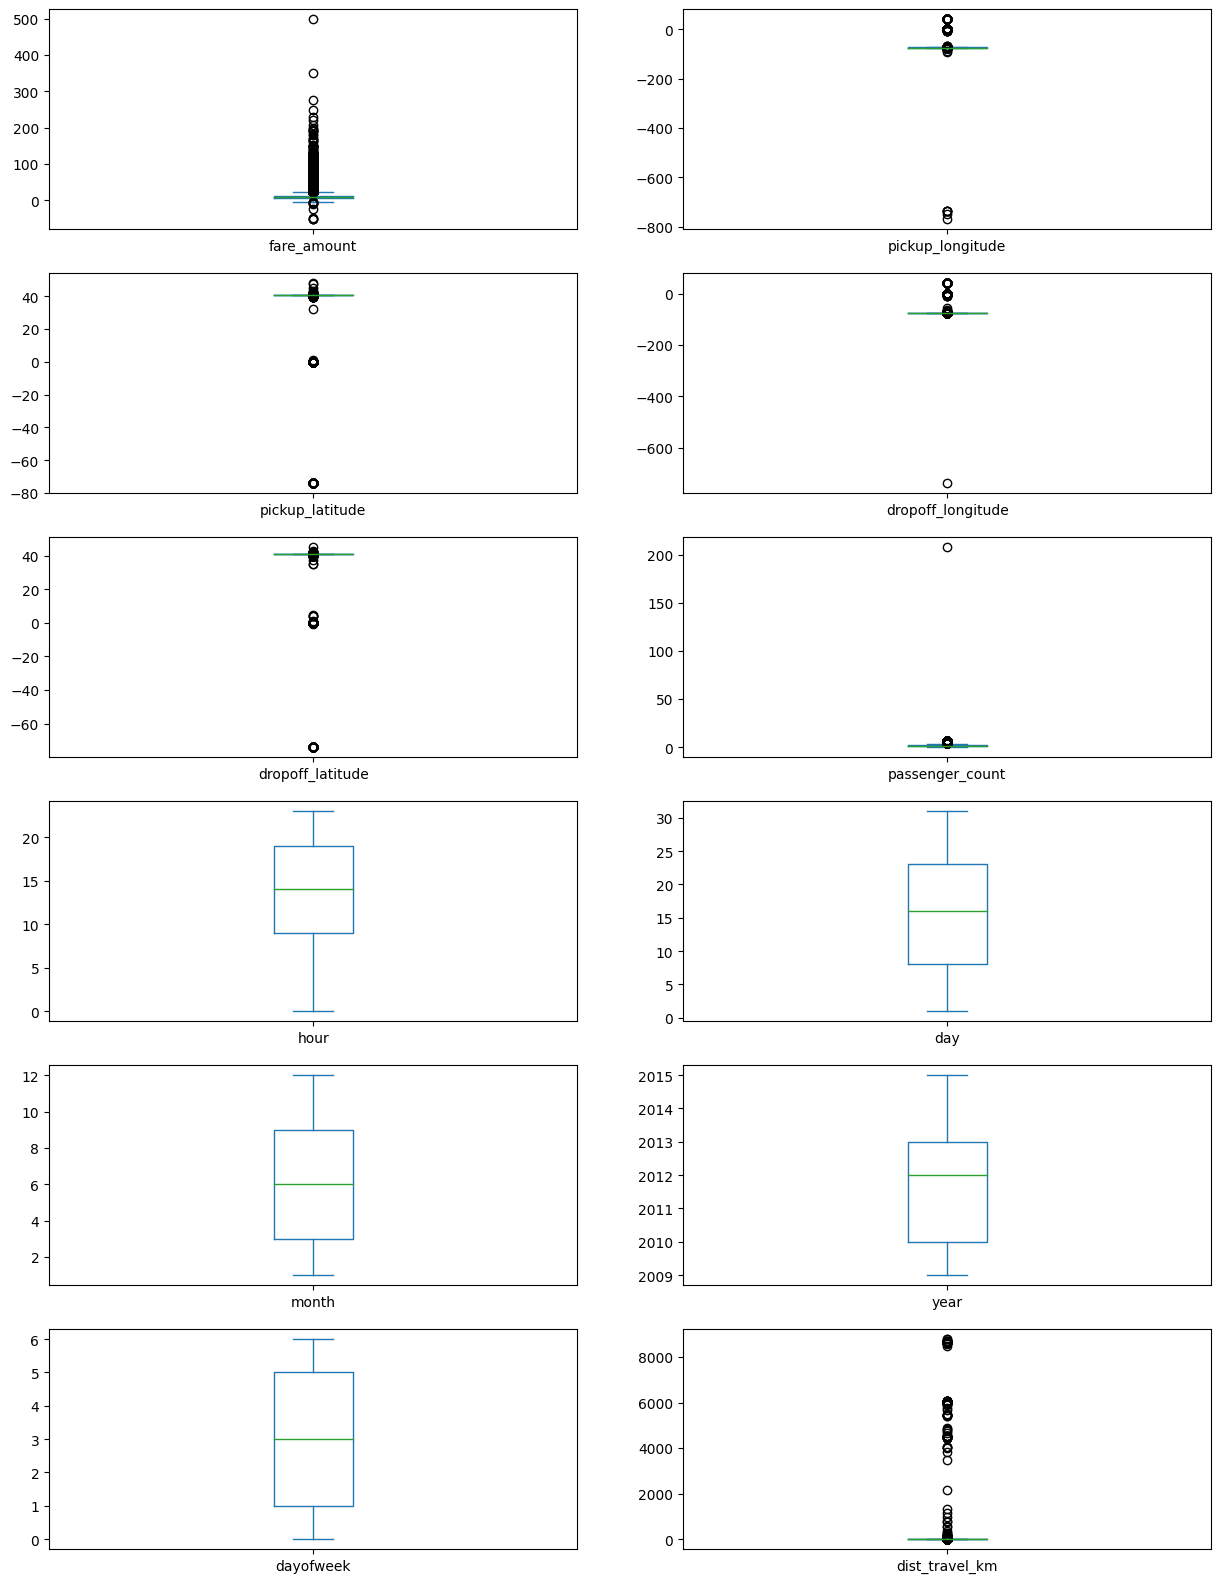

In [15]:
# 2. Identify outliers
df.plot(kind = "box", subplots = True, layout = (6, 2), figsize = (15, 20))
plt.show()

In [16]:
# Using the Inter Quartile Range to fill the values
def remove_outlier(df1, col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5*IQR
    upper_whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df1[col], lower_whisker, upper_whisker)
    return df1

def treat_outliers_all(df1, col_list):
    for c in col_list:
        df1 = remove_outlier(df, c)
    return df1

# df.iloc[:, 0 ::] is a method for selecting rows and columns in a Pandas DataFrame. In this case, : in both positions selects all rows and all columns in the DataFrame df. Essentially, it's selecting the entire DataFrame.
df = treat_outliers_all(df, df.iloc[:, 0 : : ])

<ipython-input-16-13b4b187fab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.clip(df1[col], lower_whisker, upper_whisker)
<ipython-input-16-13b4b187fab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.clip(df1[col], lower_whisker, upper_whisker)
<ipython-input-16-13b4b187fab2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

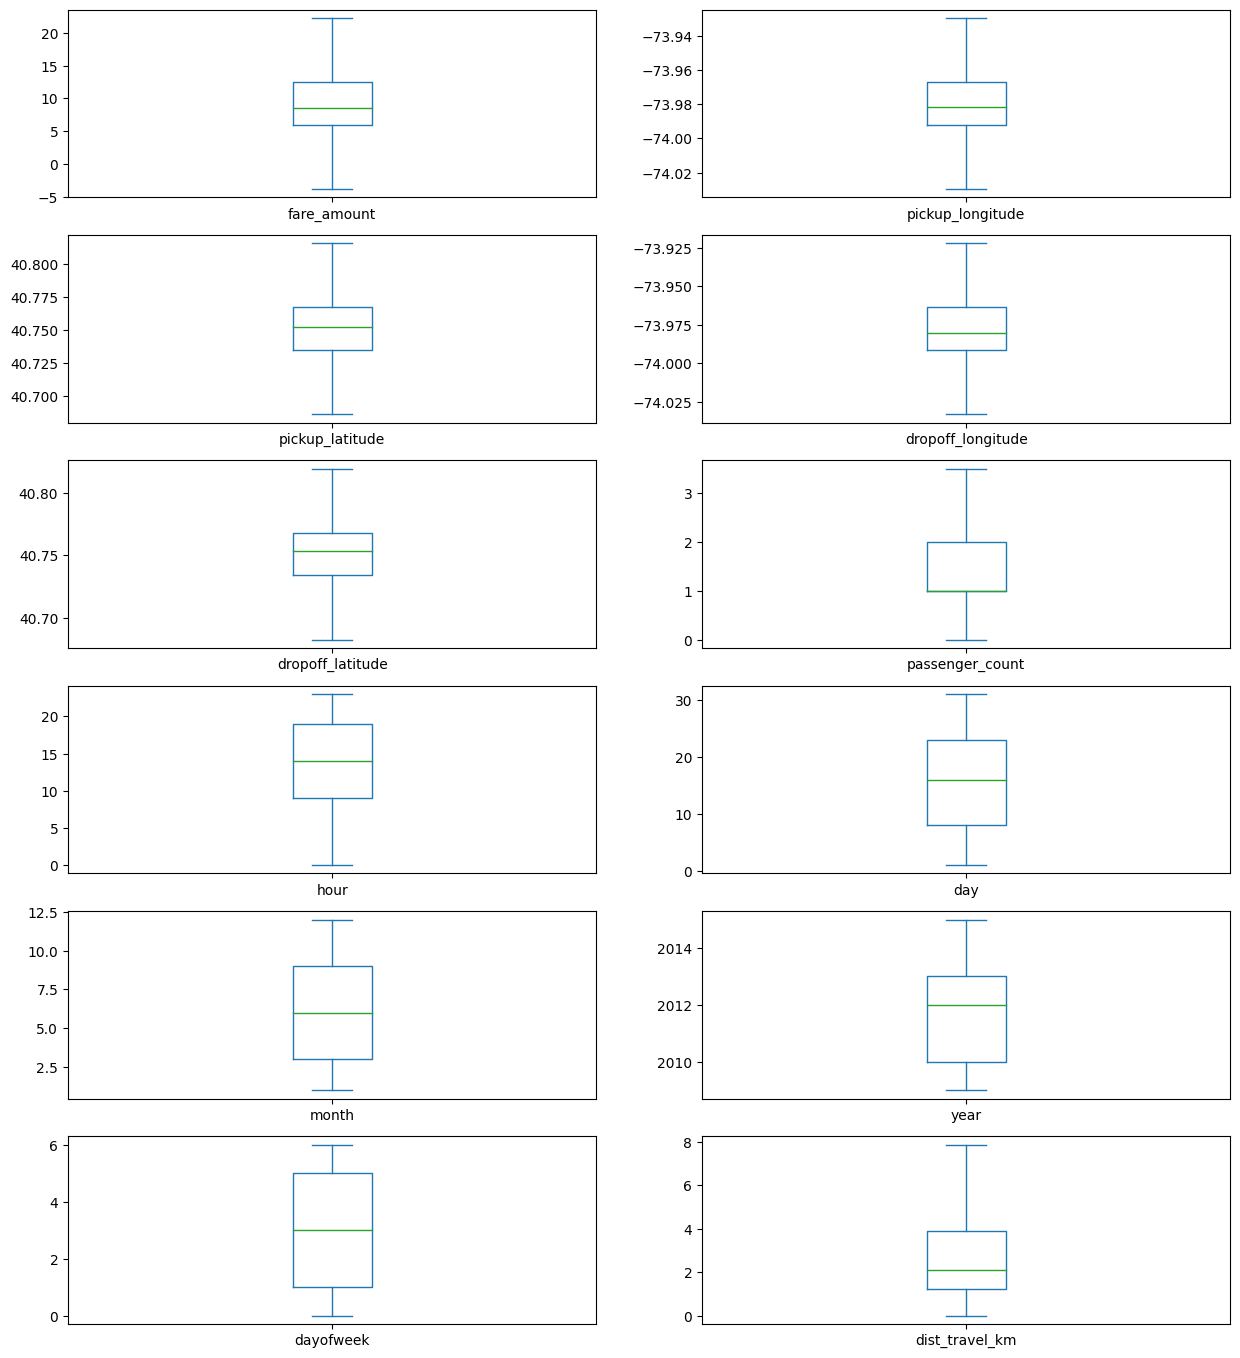

In [17]:
df.plot(kind = "box", subplots = True, layout = (7, 2), figsize = (15, 20))
plt.show()

In [18]:
# 3. Check the correlation
# .corr(): This is a Pandas method that is applied to the DataFrame df. When you call df.corr(), it calculates the pairwise correlation coefficients between all pairs of numerical columns in the DataFrame.
# Common correlation coefficients calculated by df.corr() include Pearson's correlation coefficient, Kendall's tau, and Spearman's rank correlation coefficient. By default, df.corr() computes Pearson's correlation coefficient, which is the most widely used.
corr = df.corr()
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
fare_amount,1.000000,0.154079,-0.110864,0.218684,-0.125911,0.015775,-0.023615,0.004536,0.030816,0.141282,0.013650,0.844483
pickup_longitude,0.154079,1.000000,0.259502,0.425591,0.073380,-0.013190,0.011564,-0.003215,0.001183,0.010197,-0.024633,0.098242
pickup_latitude,-0.110864,0.259502,1.000000,0.048902,0.515782,-0.012842,0.029738,-0.001526,0.001550,-0.014236,-0.042328,-0.046853
dropoff_longitude,0.218684,0.425591,0.048902,1.000000,0.245751,-0.009303,-0.046590,-0.004026,0.002408,0.011347,-0.003313,0.186844
dropoff_latitude,-0.125911,0.073380,0.515782,0.245751,1.000000,-0.006333,0.019818,-0.003465,-0.001192,-0.009606,-0.031950,-0.038874
passenger_count,0.015775,-0.013190,-0.012842,-0.009303,-0.006333,1.000000,0.020266,0.002701,0.010369,-0.009752,0.048550,0.009700
hour,-0.023615,0.011564,0.029738,-0.046590,0.019818,0.020266,1.000000,0.004660,-0.003920,0.002154,-0.086934,-0.038370
day,0.004536,-0.003215,-0.001526,-0.004026,-0.003465,0.002701,0.004660,1.000000,-0.017350,-0.012172,0.005626,0.003075
month,0.030816,0.001183,0.001550,0.002408,-0.001192,0.010369,-0.003920,-0.017350,1.000000,-0.115857,-0.008783,0.011644
year,0.141282,0.010197,-0.014236,0.011347,-0.009606,-0.009752,0.002154,-0.012172,-0.115857,1.000000,0.006112,0.024288


<Axes: >

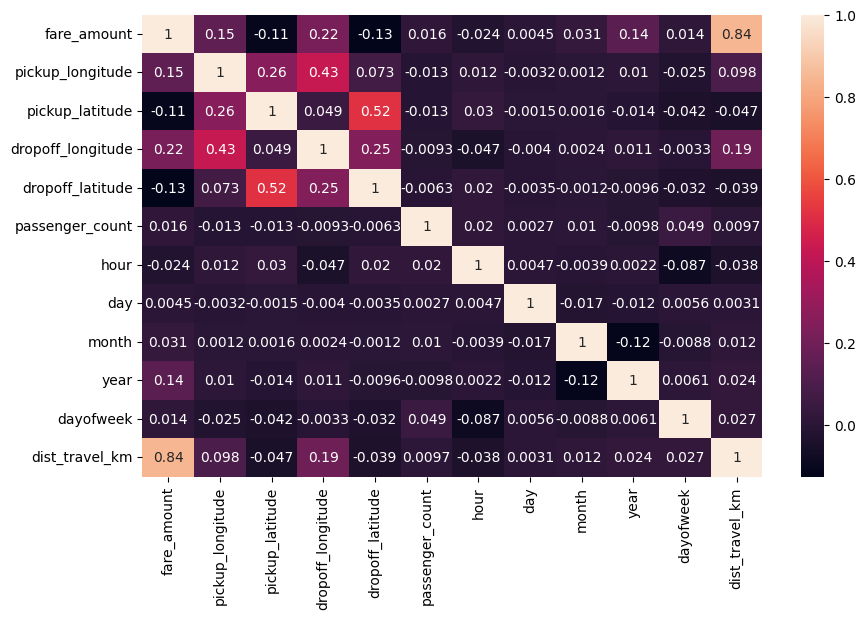

In [19]:
fig, axis = plt.subplots(figsize = (10, 6))
sns.heatmap(df.corr(), annot = True) # Correlation Heatmap (Light values means highly correlated)

In [20]:
# 4. Implement linear regression and random forest regression models
# Dividing the dataset into feature and target values
df_x = df[['passenger_count', 'hour', 'day', 'month', 'year', 'dayofweek', 'dist_travel_km']]
df_y = df['fare_amount']

In [21]:
# Dividing the dataset into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2)

In [22]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
reg = LinearRegression()

# Train the model with our training data
reg.fit(x_train, y_train)

LinearRegression()

In [23]:
y_pred_lin = reg.predict(x_test)
print(y_pred_lin)

[ 6.53617174 15.08990158  4.80558043 ...  8.2860902   7.89122
 19.65482774]


In [24]:
from sklearn.ensemble import RandomForestRegressor

# Here n_estimators means number of trees you want to build before making the prediction
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(x_train, y_train)

RandomForestRegressor()

In [25]:
y_pred_rf = rf.predict(x_test)
print(y_pred_rf)

[ 6.3525     12.8495     10.59       ...  7.316       8.545
 21.38166667]


In [26]:
# 5. Evaluate the models and compare their respective scores like R2, RMSE, etc
cols = ['Model', 'RMSE', 'R-Squared']

# Create a empty dataframe of the colums
# Columns: specifies the columns to be selected
result_tabulation = pd.DataFrame(columns = cols)

In [27]:
from sklearn import metrics
from sklearn.metrics import r2_score

reg_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin))
reg_squared = r2_score(y_test, y_pred_lin)

full_metrics = pd.Series({'Model': "Linear Regression", 'RMSE' : reg_RMSE, 'R-Squared' : reg_squared})

# Append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation.append(full_metrics, ignore_index = True)

rf_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
rf_squared = r2_score(y_test, y_pred_rf)

full_metrics = pd.Series({'Model': "Random Forest ", 'RMSE': rf_RMSE, 'R-Squared': rf_squared})
# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation.append(full_metrics, ignore_index = True)

# Print the result table
result_tabulation

<ipython-input-27-4488904525a0>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_tabulation = result_tabulation.append(full_metrics, ignore_index = True)
<ipython-input-27-4488904525a0>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_tabulation = result_tabulation.append(full_metrics, ignore_index = True)


,Model,RMSE,R-Squared
0,Linear Regression,2.834483,0.728050
1,Random Forest,2.598962,0.771366
